# Uplift Modeling with Python: Estimating the Lift from Marketing Campaigns 

Uplift modeling is a predictive modeling technique that directly models the incremental impact of a treatment on an individual's behavior. 

It is also called as "True Lift Modeling" or "Incremental Modeling"

---

# SECTION 1: Introduction to Uplift Modeling

## 1. __Types of Modeling Approaches__

In marketing analytics, the ability to predicting if a given customer is going to respond (click, buy, open email etc) or not is typically done via three types of models:

1. Look Alike models
2. Response Models
3. Uplift models

To understand and appreciate Uplift modeling, let's try to decode what the other two does and then understand what problem Uplift models solve.

__Look Alike__ models, aka, _Penetration models_ tries to find customer with similar attributes but have not yet performed the event (purchase).

In __Response Modeling__, we train ML model to learn which customers would purchase based on various attributes (including demographic and past history) and try to predict if a new customer, with given set of input, will respond.

However, both models do not consider the case that, there will be a set of customers who will:

(a) Respond anyway irrespective of giving an offer or not. 

(b) Stop purchasing if we actually make contact. In marketing, we call them 'Sleeping Dogs'.

---
<br><br><br>

## 2. __The Big Problem Uplift modeling solves__


The fundamental problem is: If a given customer may _ONLY either receive or not receive an intervention_, they CANNOT do both. 

So, to address this issue, we want to ideally know the true 'Lift' effect of being exposed to an intervention (marketing campaign like email, phone calls, targeted ads).


That is, in a marketing campaign, they can either be in the treatment group or the control group, they cannot be in both. This means that the uplift of an individual customer cannot be measured directly, it can only be estimated based on groups of similar customers. 


<br><br>
---
<br><br><br><br><br><br>


## 3. __Types of Customers__

<img src="types of customers.png" alt="Drawing" style="width: 400px;"/>

* __Sure things__ (or always-takers) are customers who were always going to buy the product, regardless of whether or not they received a marketing intervention (zero uplift).

* __Persuadables__ (or compliers) are customers who became more likely to buy the product because they received a marketing intervention (positive uplift).

* __Sleeping dogs__ (or defiers) are customers who became less likely to buy the product because they received a marketing intervention (negative uplift).

* __Lost causes__ (or never-takers) are customers who were never going to buy the product, regardless of whether or not they recieved a marketing intervention (zero uplift).


---
<br><br><br> 

## 4. __What exactly is the uplift?__

The uplift is the __'probability of purchasing if they receive the offer (A)' minus the 'probability of purchasing if they DO NOT receive the offer (B)'.__

$$Uplift = P(Purchase | Offer) - P(Purchase | No \ Offer)$$

But, Why should we subtract 'the probability if they DO NOT receive an offer?'

Because, sometimes, B can be greater than A (sleeping dogs), in which case, it is best to leave them alone. Alternately, both A and B may be equal of very low, in which case again, better not target them.

This difference in probabilities is important, because the goal of uplift modeling in such a campaign is to avoid sending offers to customers who would have purchased it anyway.



__Example Case:__

Consider a retention campaign where customers are selected to be contacted by a retention team to persuade them to continue their subscription. 
 
The goal is to only contact customers who can be persuaded to stay. We want to avoid contacting customers who always intended to stay or leave, regardless of being contacted. 
 
_More importantly, we want to avoid contacting customers who may actually be prompted to leave because we have contacted them_ (e.g. it could prompt them to shop around for a better deal when they otherwise might not have).

Specifically, uplift is the conversion rate of customers in the treatment group minus the conversion rate of customers in the control group.

#### There are multiple methods to compute the 'Uplift', which is what we are going to cover in detail in this course.

<br><br>
---
<br><br><br><br>

# SECTION 2: Uplift Modeling Workflow for Single Treatment

## 5. Import data

We will use the Hillstorm dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# pip install scikit-uplift
from sklift.datasets import fetch_hillstrom

dataset = fetch_hillstrom(target_col='visit')
data, target, treatment = dataset.data, dataset.target, dataset.treatment
data['treatment_type'] = treatment
data['target'] = target
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment_type,target
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


In [3]:
# shape
print(data.shape)

(64000, 10)


In [4]:
# Frequency Count
print(data['target'].value_counts(), "\n")
print(data['treatment_type'].value_counts(), "\n")

0    54606
1     9394
Name: target, dtype: int64 

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: treatment_type, dtype: int64 



__Describe__

In [5]:
data.describe(include=object)

,history_segment,zip_code,channel,treatment_type
count,64000,64000,64000,64000
unique,7,3,3,3
top,1) $0 - $100,Surburban,Web,Womens E-Mail
freq,22970,28776,28217,21387


__Check the frequency counts of the categories__

In [6]:
print(data["zip_code"].value_counts(), "\n")
print(data["channel"].value_counts(), "\n")

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64 

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64 



## 6. Preprocess Treatment

We will consider the treatment of both men and women email as single 'Treatment'. The rest without treatment we consider as control.

In [7]:
# No Email = 0, Mens Email = -1, Womens Email = -1
data['treatment'] = data['treatment_type'].map({'Womens E-Mail': 1, 
                                           'Mens E-Mail': 1, 
                                           'No E-Mail': 0})

data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment_type,target,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,1
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,1
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,1


__Check Data Types__


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   treatment_type   64000 non-null  object 
 9   target           64000 non-null  int64  
 10  treatment        64000 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 5.4+ MB


__One Hot Encoding__

In [9]:
data = pd.get_dummies(data)
data.head()

,recency,history,mens,womens,newbie,target,treatment,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,...,"history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,treatment_type_Mens E-Mail,treatment_type_No E-Mail,treatment_type_Womens E-Mail
0,10,142.44,1,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
1,6,329.08,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
2,7,180.65,0,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,1
3,9,675.83,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,2,45.34,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1



---
<br><br><br>

## 7. Treatment and Control

__Create X and y datasets. Also the column 'Treatment' for filtering the treatment and control datasets__

In [10]:
X = data.drop(columns=["target"])
y = data["target"]
W = data["treatment"]

In [11]:
X_treatment, y_treatment = X[W == 1], y[W == 1]
X_control, y_control = X[W == 0], y[W == 0]

In [12]:
print("Treatment: ", X_treatment.shape)
print("Control: ", X_control.shape)

Treatment:  (42694, 22)
Control:  (21306, 22)


__Make Treatment and Control in same proportion (optional)__


In [13]:
X_treatment = X_treatment.iloc[:X_control.shape[0],:]
y_treatment = y_treatment.iloc[:y_control.shape[0]]

In [14]:
print("Treatment: ", X_treatment.shape)
print("Control: ", X_control.shape)

Treatment:  (21306, 22)
Control:  (21306, 22)


__Reconstruct X and y__


In [15]:
X = pd.concat([X_treatment,X_control])
y = pd.concat([y_treatment,y_control])
print(X.shape, y.shape)

(42612, 22) (42612,)



---
<br><br><br>

## 8. Train the Models and calculate uplift

We build separate models for Control and treatment. Use the scores from both these models and compute uplift scores.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
# Building logistic regression models for treatment and control groups
model_treatment = LogisticRegression(random_state=42, max_iter=1000)
model_control = LogisticRegression(random_state=42, max_iter=1000)

The above model did not converge initially with the default 100 iterations. Increase `max_iter=1000` for it to converge.

__Train__

In [18]:
model_treatment.fit(X_treatment, y_treatment)
model_control.fit(X_control, y_control)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Predicting probabilities
prob_treatment = model_treatment.predict_proba(X)[:, 1]
prob_control = model_control.predict_proba(X)[:, 1]

__View Scores__

In [20]:
print(prob_treatment[:5])
print(prob_control[:5])

[0.10437026 0.12166057 0.17799746 0.16999192 0.15972841]
[0.13421513 0.10637812 0.21882415 0.2675556  0.1632066 ]


In [21]:
print(prob_treatment.shape)
print(prob_control.shape)

(42612,)
(42612,)


__Calc Uplift__

Uplift is calculated as the difference between the corresponding prediction scores of treatment and control samples.

In [22]:
# Calculating uplift
uplift = prob_treatment - prob_control
print(uplift)

[-0.02984488  0.01528245 -0.04082668 ...  0.2448536   0.16099625
  0.2137267 ]


So, a negative value of Uplift would imply that, targeting such individuals could be detrimental to the campaign.

---
<br><br><br>


## 9. Extracting the four types of customers

__Logic:__

1. __Persuadables:__ Won't buy unless treated

    P(R|T) > 0.5 AND P(R|C) < 0.5  (aka P(R|T) > P(R|C))

2. __Sleeping Dogs:__ Stop buying IF treated, else, will buy

    P(R|T) < 0.5 AND P(R|C) > 0.5  (aka P(R|T) < P(R|C))

3. __Lost Causes:__ Will NOT buy

    P(R|T) < 0.5 & P(R|C) < 0.5

5. __Sure Things:__ Will surely buy with or without treatment

    P(R|T) > 0.5 & P(R|C) > 0.5

In [23]:
# Ranking individuals by uplift scores
indices = np.argsort(uplift)[::-1]
sorted_uplift = uplift[indices]

# sort Y, W, treatment and control scores as well.
sorted_y = y.to_numpy()[indices]
sorted_W = W.to_numpy()[indices]
sorted_treatment = prob_treatment[indices]
sorted_control = prob_control[indices]

__1. Persuadables - Top few scores: People likely to be persuaded by treatment to respond__

In [24]:
print("Uplift:           ", sorted_uplift[:10].round(2),"\n",
      "Y:                ", sorted_y[:10], "\n",
      "Treatment type:   ", sorted_W[:10], "\n",
      "Treatment scores: ", prob_treatment[indices][:10].round(2), "\n",
      "Control scores:   ", prob_control[indices][:10].round(2), "\n")

Uplift:            [0.34 0.34 0.34 0.34 0.34 0.34 0.34 0.34 0.34 0.34] 
 Y:                 [0 0 0 0 0 0 0 0 1 0] 
 Treatment type:    [1 1 1 0 0 0 1 1 0 1] 
 Treatment scores:  [0.48 0.49 0.49 0.49 0.49 0.49 0.52 0.49 0.52 0.48] 
 Control scores:    [0.14 0.15 0.15 0.15 0.15 0.15 0.18 0.15 0.18 0.14] 



__2. Sleeping Dogs - Bottom few scores: People Change their mind when exposed to treatment__

In [25]:
print("Uplift:           ", sorted_uplift[-10:].round(2),"\n",
      "Y:                ", sorted_y[-10:], "\n",
      "Treatment type:   ", sorted_W[-10:], "\n",
      "Treatment scores: ", prob_treatment[indices][-10:].round(2), "\n",
      "Control scores:   ", prob_control[indices][-10:].round(2), "\n")

Uplift:            [-0.2  -0.2  -0.21 -0.21 -0.21 -0.21 -0.21 -0.21 -0.21 -0.22] 
 Y:                 [0 0 1 0 0 0 0 0 0 0] 
 Treatment type:    [1 1 1 1 0 0 1 1 1 1] 
 Treatment scores:  [0.25 0.25 0.22 0.26 0.26 0.23 0.26 0.23 0.23 0.23] 
 Control scores:    [0.45 0.46 0.43 0.47 0.47 0.44 0.47 0.45 0.45 0.45] 



__Assign the predicted customer category for each record__

In [26]:
df_scores = pd.DataFrame({"y":sorted_y, 
                          "treatment": sorted_W,
                          "prob_T": prob_treatment[indices], 
                          "prob_C":prob_control[indices], 
                          "uplift":sorted_uplift}).round(4)

df_scores.head()

,y,treatment,prob_T,prob_C,uplift
0,0,1,0.4756,0.1368,0.3388
1,0,1,0.4900,0.1513,0.3387
2,0,1,0.4901,0.1516,0.3385
3,0,0,0.4901,0.1517,0.3384
4,0,0,0.4901,0.1518,0.3384


In [27]:
df_scores.treatment.value_counts()

1    28404
0    14208
Name: treatment, dtype: int64

In [28]:
# Assign Predicted Customr Types

def set_cust_type(df_scores=df_scores,cutoff=0.5):
    df_scores['type'] = ""
    # Persuadables:  P(R|T) > 0.5 AND P(R|C) < 0.5  (aka P(R|T) > P(R|C))
    df_scores.loc[(df_scores.prob_T >= cutoff) & (df_scores.prob_C < cutoff), 'type'] = "persuadable"        
    # Sleeping Dogs: P(R|T) < 0.5 AND P(R|C) > 0.5  (aka P(R|T) < P(R|C))
    df_scores.loc[(df_scores.prob_T < cutoff) & (df_scores.prob_C >= cutoff), 'type'] = "sleeping_dog"
    # Lost Causes: P(R|T) < 0.5 & P(R|C) < 0.5
    df_scores.loc[(df_scores.prob_T < cutoff) & (df_scores.prob_C < cutoff), 'type'] = "lost_cause"
    # Sure things: P(R|T) > 0.5 & P(R|C) > 0.5
    df_scores.loc[(df_scores.prob_T >= cutoff) & (df_scores.prob_C > cutoff), 'type'] = "sure_thing"
    # Check 
    print("Freq Count:\n", df_scores['type'].value_counts())
    return(df_scores)

# Apply
df_scores = set_cust_type(df_scores)

Freq Count:
 lost_cause      41854
persuadable       728
sleeping_dog       28
sure_thing          2
Name: type, dtype: int64


Looks like we have 1 sure thing. Let's check it out.

In [29]:
df_scores.loc[df_scores.type=="sure_thing", :] 

,y,treatment,prob_T,prob_C,uplift,type
41169,1,0,0.5000,0.5919,-0.0919,sure_thing
41221,1,1,0.5003,0.5931,-0.0928,sure_thing


This customer is a surething, but has a negative uplift. So better leave him alone and not run campaign on him.

__FAQ:__ If 'surething' AND the uplift is positive, should we do treatment? 

__Ans:__ Well, it's a business decision, mostly depending on budget. If sufficient budgest available, and profit from the product sale justifies the cost of acquisition, then might be a good idea to treat.

Another problem is most of them are lost causes. We can fix this by lowering the cutoff score.

__Changing the cutoff from .5 to .3__

In [30]:
# Apply
df_scores = set_cust_type(df_scores, cutoff=0.3)
df_scores.head()

Freq Count:
 lost_cause      30641
persuadable      9734
sleeping_dog     1341
sure_thing        896
Name: type, dtype: int64


,y,treatment,prob_T,prob_C,uplift,type
0,0,1,0.4756,0.1368,0.3388,persuadable
1,0,1,0.4900,0.1513,0.3387,persuadable
2,0,1,0.4901,0.1516,0.3385,persuadable
3,0,0,0.4901,0.1517,0.3384,persuadable
4,0,0,0.4901,0.1518,0.3384,persuadable


__Let's look at few random examples__

In [31]:
df_scores.sample(10)

,y,treatment,prob_T,prob_C,uplift,type
2552,0,0,0.3855,0.1306,0.2549,persuadable
15646,0,1,0.2630,0.1048,0.1582,lost_cause
21953,0,0,0.1325,0.0838,0.0486,lost_cause
26206,1,1,0.2820,0.2660,0.0160,lost_cause
14013,1,0,0.2997,0.1332,0.1665,lost_cause
2273,0,1,0.4890,0.2305,0.2586,persuadable
39363,0,1,0.1235,0.1871,-0.0637,lost_cause
13634,0,1,0.2369,0.0690,0.1678,lost_cause
7834,0,1,0.2926,0.0838,0.2088,lost_cause
11918,1,0,0.3179,0.1398,0.1782,persuadable


Since the concept of Persuadable or not changes with the cutoff, how do we decide if a given customer is actually persuadable or not?

- --> Consider all +ve uplift scores + the treatment score is sufficiently high.
- --> Alternately, study the QINI curve and see where you want to cut.

The dataset is already sorted by uplift so just take the customers from the top.

Let's draw a random sample from the top 1000 records.

In [32]:
df_scores.head(1000).sample(20)

,y,treatment,prob_T,prob_C,uplift,type
111,1,0,0.5370,0.2093,0.3277,persuadable
542,0,1,0.5657,0.2576,0.3081,persuadable
623,0,1,0.5436,0.2396,0.3040,persuadable
223,1,0,0.4566,0.1358,0.3208,persuadable
143,0,1,0.5243,0.1993,0.3250,persuadable
403,0,1,0.4748,0.1610,0.3138,persuadable
791,0,0,0.4458,0.1493,0.2964,persuadable
835,0,0,0.4305,0.1355,0.2949,persuadable
576,1,0,0.4317,0.1255,0.3063,persuadable
921,0,1,0.4317,0.1399,0.2918,persuadable


---
<br><br><br>


## 10. QINI Curve

Rank the individuals based on the uplift scores and calc cumulative uplift.

In [33]:
def qini_rank(df_scores):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'y':[]})
    ranked['y'] = df_scores['y']
    ranked['uplift'] = df_scores['uplift']
    ranked['treatment'] = df_scores['treatment']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

ranked = qini_rank(df_scores)
ranked.head()

,n,y,uplift,treatment
0,0.000023,0,0.3388,1
1,0.000047,0,0.3387,1
2,0.000070,0,0.3385,1
3,0.000106,0,0.3384,0
4,0.000106,0,0.3384,0


In [34]:
def qini_eval(ranked):
    """
    Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['treatment'] == 0), sum(ranked['treatment'] == 1)
    # print(C, T)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[(ranked.y == 1) & (ranked.treatment==0),'cr'] = 1
    ranked.loc[(ranked.y == 1) & (ranked.treatment==1),'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift_cumu'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    # print(uplift_model['uplift_cumu'].tail(15))
    # print(uplift_model['uplift_cumu'].iloc[-1])
    random_model['uplift_cumu'] = round(ranked['n'] * uplift_model['uplift_cumu'].iloc[-1],5)
    
    # Add first datapoint
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'y': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by=['n', 'model']).reset_index(drop = True)
    return merged

df_qini = qini_eval(ranked)
df_qini.head(14)

14208 28404
42597    0.00125
42598    0.00125
42599    0.00125
42600    0.00129
42601    0.00129
42602    0.00129
42603    0.00129
42604    0.00132
42605    0.00132
42606    0.00132
42607    0.00132
42608    0.00132
42609    0.00132
42610    0.00132
42611    0.00132
Name: uplift_cumu, dtype: float64
0.00132


,n,uplift,y,treatment,uplift_cumu,model
0,0.000000,0.0000,None,NaN,NaN,Random model
1,0.000000,0.0000,None,NaN,NaN,Uplift model
2,0.000023,0.3388,0,1.0,0.0,Random model
3,0.000023,0.3388,0,1.0,0.0,Uplift model
4,0.000047,0.3387,0,1.0,0.0,Random model
5,0.000047,0.3387,0,1.0,0.0,Uplift model
6,0.000070,0.3385,0,1.0,0.0,Random model
7,0.000070,0.3385,0,1.0,0.0,Uplift model
8,0.000106,0.3384,0,0.0,0.0,Random model
9,0.000106,0.3384,0,0.0,0.0,Random model


In [35]:
df_qini.loc[df_qini.model=="Random model", "uplift_cumu"].describe()

count    42612.000000
mean         0.000660
std          0.000381
min          0.000000
25%          0.000330
50%          0.000660
75%          0.000990
max          0.001320
Name: uplift_cumu, dtype: float64

__Plot__

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: xlabel='Proportion targeted', ylabel='Uplift Cumulative'>

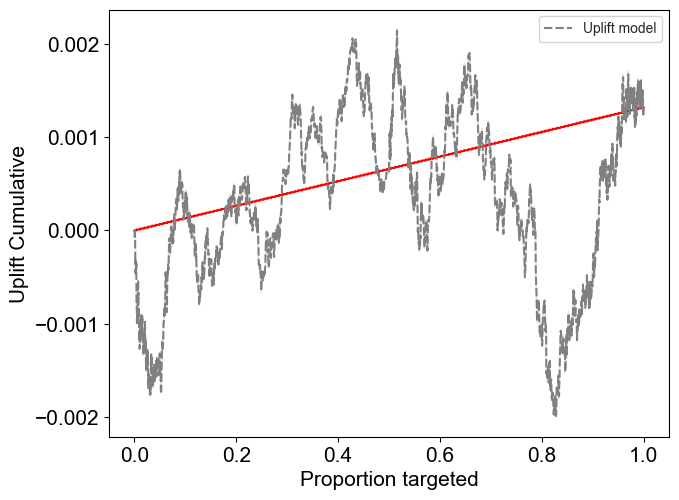

In [37]:
def qini_plot(df_qini):
    """
    Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', 
                      y='uplift_cumu', 
                      hue='model', 
                      data=df_qini,
                      style='model', 
                      palette=['red','grey'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift Cumulative',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax

qini_plot(df_qini)

---
<br><br><br>

## 11. Self Assessment

1. Repeat the whole exercise using XGBoost model instead of Logistic regression and draw the QINI curve.
2. Compare and contrast the results. Examine if there are instances where the logistic regression proposes as a 'Persuadable' but XGBoost proposes as 'Sleeping Dog'. Why could it be so? 


<br><br><br><br><br>
---